step 1 generate a blob with the GAN that looks vaguely pokemon like (success)

Smooth and Quantize Colors.

step 2 evaluate the cohesiveness of the blob. (cycle to step 1 until we find a cohesive enough blob)

step 3 clean up colos by getting rid of stuff where it should be white, adding a black outline.

step 4 pick a head.

step 5 add eyes to the head.

step 6 pokemon done

https://docs.opencv.org/3.3.1/d5/d69/tutorial_py_non_local_means.html

https://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html

https://www.pyimagesearch.com/2014/07/07/color-quantization-opencv-using-k-means-clustering/

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data
from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets
from torchvision.utils import make_grid

In [10]:
# params
n_epochs = 125
batch_size = 64
lr = 0.0002
label_smooth = 0.9
pokemon_models = os.path.join('models')
image_path = os.path.join('imgs','pokemon')
mnist_img = os.path.join('imgs','mnist')
# params generator
noise_dim = 100
g_filter_depth = 64
# params discriminator
d_filter_depth_in = 3
d_filter_depth = 64

In [15]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 
                              512, 
                              kernel_size=4, 
                              stride=1, 
                              padding=0,
                              bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 
                              256, 
                              kernel_size=4, 
                              stride=2,
                              padding=1,
                              bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 
                              128, 
                              kernel_size=4, 
                              stride=2, 
                              padding=1,
                              bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 
                              64, 
                              kernel_size=4, 
                              stride=2, 
                              padding=1,
                              bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 
                               d_filter_depth_in,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()
        )
        
    def forward(self, inputs):
        # add two single dimensions
        output = self.main(inputs)
        return output

def denorm_monsters(x):
    '''
    convert images to be (0, 1)
    '''
    renorm = (x*0.5)+0.5
    return renorm.clamp(0,1)



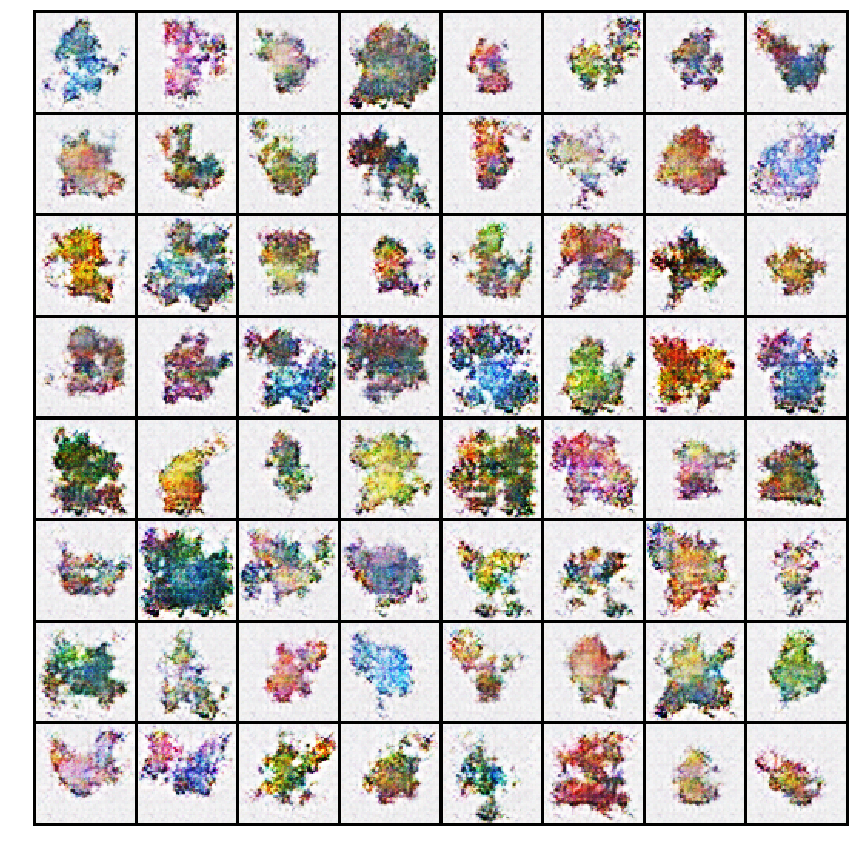

In [16]:
fixed_noise = Variable(torch.randn(batch_size, noise_dim, 1, 1))
load_model = os.path.join('models', 'generator_ep_%d' % 110)
generator_final = Generator()
generator_final.load_state_dict(torch.load(load_model, map_location={"cuda:0": "cpu"}))
fixed_imgs = generator_final(fixed_noise)
result = denorm_monsters(fixed_imgs.cpu().data)
result = make_grid(result)
result = transforms.Compose([transforms.ToPILImage()])(result)
plt.figure(figsize=(20,15))
plt.imshow(result)
plt.axis('off')
_ = plt.show()         

# Smooth and Quantize Colors

Smothing images with a bilateral filter is a good idea because bilateral filters preserver edges. The bilateral smoothing function takes into account the difference in pixel intensities.

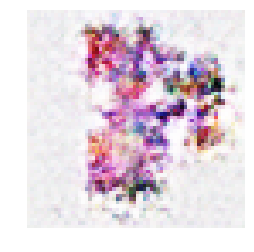

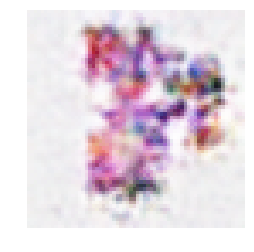

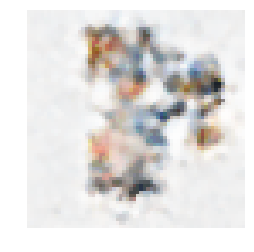

In [1527]:
from scipy import ndimage
# check smooth
fixed_imgs = generator_final(fixed_noise)
result = denorm_monsters(fixed_imgs.cpu().data[1])
result_orig = np.transpose(result.numpy(), (1,2,0))
result_blur = cv2.bilateralFilter(result_orig, 3,25,25)
result_filt = ndimage.median_filter(result_orig, size=3)
plt.imshow(result_orig)
plt.axis('off')
plt.show()
plt.imshow(result_blur)
plt.axis('off')
plt.show()
plt.imshow(result_filt)
plt.axis('off')
plt.show()

To quantize we will use minibatch kmeans which is usually faster than regular kmeans. Basically we convert the color to LAB space. Then cluster our color in lab space. Then we get the clusters centers for those clusters and those become the primary colors we choose to use for our opkemon. Then we assign every pixel to one of these colors. The overall effect is to simplify a complex image.

In [1528]:
# try quantizing
from sklearn.cluster import MiniBatchKMeans

def simplify_pokemon(result_in):
    h,w = result_in.shape[0:2]
    image = cv2.cvtColor(result_in, cv2.COLOR_BGR2LAB)
    km = MiniBatchKMeans(n_clusters=9)
    clusters = km.fit_predict(image.reshape(-1, 3))
    quant = km.cluster_centers_[clusters].reshape((h,w,3))
    quant = cv2.cvtColor(quant, cv2.COLOR_LAB2BGR)
    return quant

def get_luminance(pixel):
    return (0.299 * pixel[0] + 0.587 * pixel[1] + 0.114 * pixel[2])

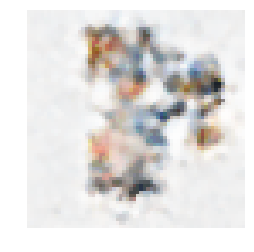

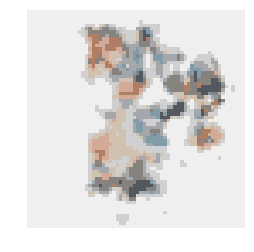

In [1529]:
# fill in every white pixel with the nearest neighbor.
smooth_monsters = simplify_pokemon(result_filt)
plt.imshow(result_filt)
plt.axis('off')
plt.show()
plt.imshow(smooth_monsters)
plt.axis('off')
plt.show()

In [1553]:
def enlarge_eyes(monster_image):
    # find all the connected whitespace
    gray = cv2.cvtColor(monster_image, cv2.COLOR_BGR2GRAY)
    a = (gray*255).astype(np.uint8) 
    ret,thr = cv2.threshold(a, 0, 255, cv2.THRESH_OTSU)
    n, labels, stats, centroids = cv2.connectedComponentsWithStats(thr, 8, cv2.CV_32S)

    # find the two biggest connected whitespaces that
    # are not the gigantic background
    best_i = None
    best_eye = 0
    best_eye_label = None
    next_best_eye = 0
    next_best_eye_label = None
    for i,stat in enumerate(stats):
        if stat[-1] < 100 and stat[-1] > 3 and stat[-1] > best_eye:
            best_eye = stat[-1]
            best_eye_label = i
        elif stat[-1] < 100 and stat[-1] > 3 and stat[-1] > next_best_eye:
            next_best_eye = stat[-1]
            next_best_eye_label = i

    # get the pixels belonging to our two eye candidates
    best_eye_pixels = np.where(labels == best_eye_label)
    next_best_eye_pixels = np.where(labels == next_best_eye_label)
    
#     # enlarge the eye by setting all pixels
#     # part fo that connected component to be
#     # white
    result_eye = monster_image.copy()
    for eye in [best_eye_pixels, next_best_eye_pixels]:
        if not eye:
            break
        for h,w in zip(eye[0], eye[1]):
            for height in range(h, h+1):
                for width in range(w, w+1):
                    result_eye[height][width][0] = 0.8
                    result_eye[height][width][1] = 0.8
                    result_eye[height][width][2] = 0.8
            
    eye_looks_right = np.random.rand() > 0.5
            
    for label in [best_eye_label, next_best_eye_label]:
        if not label:
            break
        best_centroid = tuple(map(int, centroids[label]))
        h, w = best_centroid[1],best_centroid[0]
        for height in range(h-2, h+3):
            for width in range(w-2, w+3):
                if height in [h+2, h-2] and width in [w-2, w+2]:
                    continue
                result_eye[height][width][0] = 0.9
                result_eye[height][width][1] = 0.9
                result_eye[height][width][2] = 0.9
                if eye_looks_right:
                    if height > h and width > w:
                        result_eye[height][width][0] = 0.0
                        result_eye[height][width][1] = 0.0
                        result_eye[height][width][2] = 0.0
                        result_eye[height-1][width][0] = 0.0
                        result_eye[height-1][width][1] = 0.0
                        result_eye[height-1][width][2] = 0.0
                else:
                    if height > h and width < w:
                        result_eye[height][width][0] = 0.0
                        result_eye[height][width][1] = 0.0
                        result_eye[height][width][2] = 0.0
                        result_eye[height-1][width][0] = 0.0
                        result_eye[height-1][width][1] = 0.0
                        result_eye[height-1][width][2] = 0.0
                        
    return result_eye

In [1554]:
np.array([139, 51, 51])/255

array([ 0.54509804,  0.2       ,  0.2       ])

In [1555]:
res = enlarge_eyes(smooth_monsters)

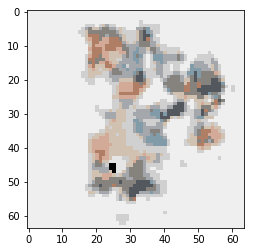

In [1556]:
plt.imshow(res)
plt.show()

In [1587]:
simple_monsters = []

for i in range(64):
    result = denorm_monsters(fixed_imgs.cpu().data[i])
    monster = np.transpose(result.numpy(), (1,2,0))
    monster = median_filter(monster, size=3)
    monster = enlarge_eyes(monster)
    monster = simplify_pokemon(monster)
    simple_monsters.append(monster)
simple_monsters = (np.array(simple_monsters)*255).astype(np.uint8)
simple_monsters.shape

(64, 64, 64, 3)

In [1588]:
torch_monsters = []
for i in range(simple_monsters.shape[0]):
    simple_monsters_tensor = transforms.Compose([transforms.ToTensor()])(simple_monsters[i])
    torch_monsters.append(simple_monsters_tensor)
torch_monsters = torch.stack(torch_monsters)
torch_monsters.shape

torch.Size([64, 3, 64, 64])

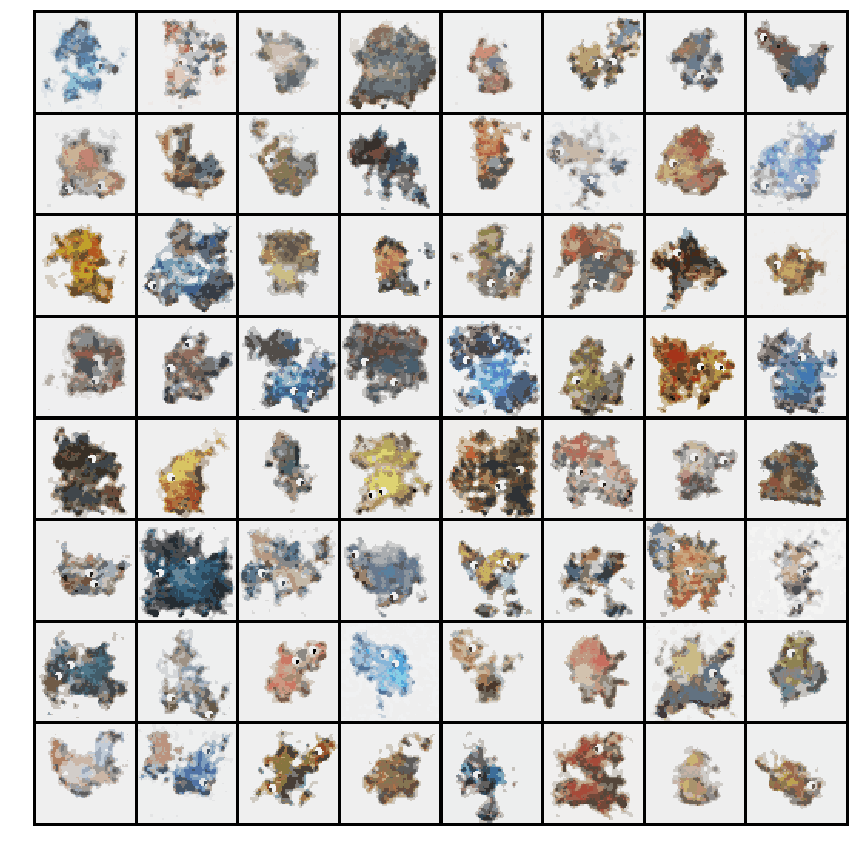

In [1589]:
grid_simple = make_grid(torch_monsters)
grid_simple = transforms.Compose([transforms.ToPILImage()])(grid_simple)
plt.figure(figsize=(20,15))
plt.imshow(grid_simple)
plt.axis('off')
plt.show()

There look alright. They aren't perfect but i'd say there's at least a few monsters here with a decent look. The upside of generative models is that we can generate an infinite number. 

So we can just pick the ones we want, then regenerate and pick some more that look good.

In [595]:
for idx in np.ndenumerate(quant):
    
    pixel = quant[idx[0][:2]]
    print(get_luminance())

0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.9325

0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.9325

0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.496512155145
0.496512155145
0.496512155145
0.496512155145
0.496512155145
0.496512155145
0.496512155145
0.496512155145
0.496512155145
0.574406423271
0.574406423271
0.574406423271
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.932582

0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.496512155145
0.496512155145
0.496512155145
0.496512155145
0.496512155145
0.496512155145
0.496512155145
0.496512155145
0.496512155145
0.253374392107


0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.93258283031
0.93258283031
0.93258283031
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.574406423271
0.574406423271
0.574406423271
0.496512155145
0.496512155145
0.496512155145
0.687965260565
0.687965260565
0.687965260565
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.687965260565
0.687965260565
0.687965260565
0.496512155145
0.496512155145
0.496512155145
0.574406423271
0.574406423271
0.574406423271
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.932

0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.754157133698
0.754157133698
0.754157133698
0.754157133698
0.754157133698
0.754157133698
0.708567579806
0.708567579806
0.708567579806
0.708567579806
0.708567579806
0.708567579806
0.754157133698
0.754157133698
0.754157133698
0.754157133698
0.754157133698
0.754157133698
0.754157133698
0.754157133698
0.754157133698
0.574406423271
0.574406423271
0.574406423271
0.574406423271
0.574406423271
0.574406423271
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565
0.687965260565

0.754157133698
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.932

0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.708567579806
0.708567579806
0.708567579806
0.708567579806
0.708567579806
0.708567579806
0.708567579806
0.708567579806
0.708567579806
0.420842068851
0.420842068851
0.420842068851
0.420842068851
0.420842068851
0.420842068851
0.505026260614
0.505026260614
0.505026260614
0.505026260614
0.505026260614
0.505026260614
0.505026260614
0.505026260614
0.505026260614
0.505026260614
0.505026260614
0.505026260614
0.754157133698
0.754157133698
0.754157133698
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93

0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.93258283031
0.9325

0.253374392107
0.253374392107
0.253374392107
0.253374392107
0.253374392107
0.574406423271
0.574406423271
0.574406423271
0.574406423271
0.574406423271
0.574406423271
0.253374392107
0.253374392107
0.253374392107
0.253374392107
0.253374392107
0.253374392107
0.496512155145
0.496512155145
0.496512155145
0.496512155145
0.496512155145
0.496512155145
0.574406423271
0.574406423271
0.574406423271
0.574406423271
0.574406423271
0.574406423271
0.574406423271
0.574406423271
0.574406423271
0.574406423271
0.574406423271
0.574406423271
0.574406423271
0.574406423271
0.574406423271
0.574406423271
0.574406423271
0.574406423271
0.754157133698
0.754157133698
0.754157133698
0.574406423271
0.574406423271
0.574406423271
0.754157133698
0.754157133698
0.754157133698
0.420842068851
0.420842068851
0.420842068851
0.505026260614
0.505026260614
0.505026260614
0.754157133698
0.754157133698
0.754157133698
0.420842068851
0.420842068851
0.420842068851
0.420842068851
0.420842068851
0.420842068851
0.708567579806
0.70856757